# pandas-ml-qunat - The Pandas Machine Leraning and Quant Finance Library

[![Python 3.7](https://img.shields.io/badge/python-3.7-blue.svg)](https://www.python.org/downloads/release/python-360/)
[![Actions Status](https://github.com/KIC/pandas-ml-qunat/workflows/Python%20package/badge.svg)](https://github.com/KIC/pandas-ml-qunat/actions?query=branch%3Amaster)


This is the root repository of the follwoing 3 core components:

* [pandas-ml-common](../pandas-ml-common/Readme.md) - a more general utilities and monkey patched pandas objects provider
* [pandas-ml-quant](../pandas-ml-quant/Readme.md) - provides technical analysis inidcators, plots, loss functions, etc.
* [pandas-ml-utils](../pandas-ml-utils/Readme.md) - apply statistical or ml models directly to data frames

You will also find an integration test module which is used mainly for testing but may also serve as a source of documentation.

Last but not least there are some notebooks which I use for my experiments feel free to use them as well. 

## Installation
Currenty all 3 libraries are very much entangled. This dependency will weaken up as we reach stablity. Never the less it is possible to only use `pandas-ml-utils` together with `pandas-ml-common`.

```bash
pip install pandas-ml-common pandas-ml-utils pandas-ml-quant
```

## Demonstration of all 3 libraries used together
### First import needed objects

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os
import sys
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from pandas_ml_utils.ml.data.extraction import extract_with_post_processor
from pandas_ml_utils.ml.summary import ClassificationSummary
from pandas_ml_utils import FeaturesAndLabels, Model, SkModel
from pandas_ml_quant import pd, np

automatically imported pandas_ml_utils 0.1.1


### Next fetch some stock data and plot it

Note that:
1. all indicators and charting functionalities are behind the **q**and property attached to all pandas objects
1. the **m**achine**l**earning proptery provides access to (raw) data as it is useful/needed by statistical and ml models
1. all model relevant functionalities are behind the **model** property


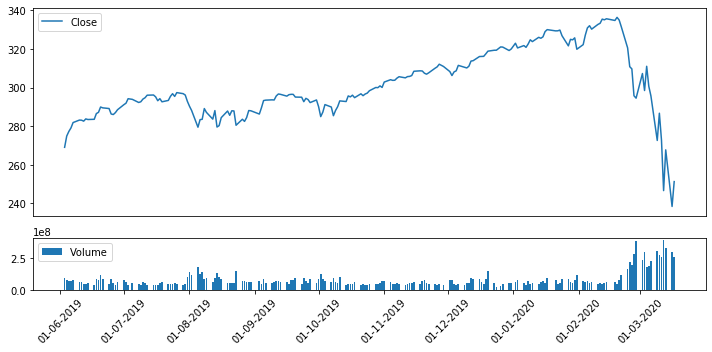

In [2]:
df = pd.fetch_yahoo("SPY").loc[:'2020-03-17']

# NOTE the access to the q_uant property
df[-200:].ta.plot(figsize=(10, 5))()

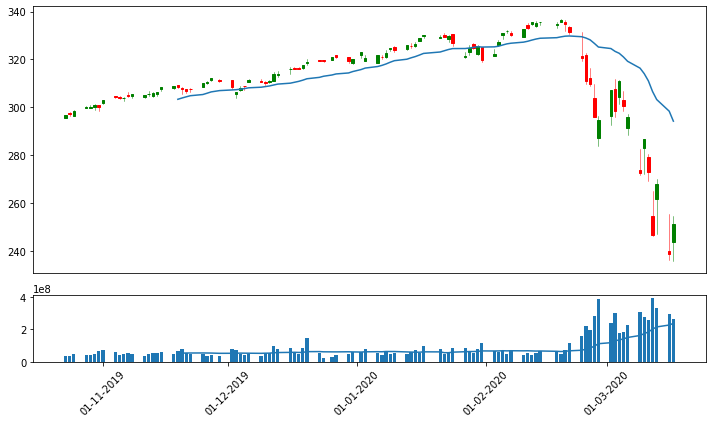

In [3]:
plt = df[-100:].ta.plot(figsize=(10, 6))
plt.candlestick()
plt.line(df[-100:]["Close"].ta.sma(period=20))
plt.bar("Volume")
plt.line(df[-100:]["Volume"].ta.sma(period=20), panel=1)

### Now think of a predictive model
Lets say we want to predict in which quantile of a bolliner bands indicator the price in the future will be:
* 0 means below lower band
* 1 means in the middle band
* 2 means above the upper band


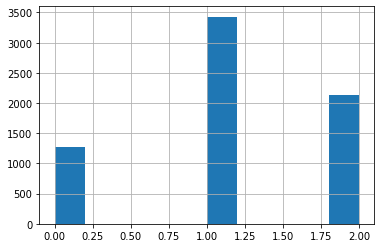

In [4]:
# NOTE all technical analysis starts with the "ta_" prefix
df["Close"].ta.future_bband_quantile(5, 5).hist()

And we want to predict this event based on a set of indicators like the RSI (Relative Strength Index) and such.

So we can build up a features and labels definition like so:

In [5]:
fnl = FeaturesAndLabels(
    features=[
        lambda df: df["Close"].ta.macd(),
        lambda df: df["Close"].ta.apo(),
        lambda df: df["Close"].ta.rsi(),
        lambda df: df["Close"].ta.roc(),
        lambda df: df["Close"].ta.trix(),
        lambda df: df["Close"].ta.ppo(),
        lambda df: df["Close"].pct_change().ta.zscore() / 4.,
        lambda df: df["Close"].ta.week_day(),
        lambda df: df["Close"].ta.week(),
        lambda df: df["Close"].ta.up_down_volatility_ratio(),
        lambda df: df.ta.adx(), 
        lambda df: df.ta.atr(),
        lambda df: df.ta.tr(),
        lambda df: df.ta.williams_R(),
        lambda df: df.ta.ultimate_osc(),
        lambda df: df.ta.bop(),
        lambda df: df.ta.cci(),
    ],
    labels=[
        lambda df: df["Close"].ta.future_bband_quantile(5, 5)
    ]
)

# NOTE the df.ml property provides access to (raw) data as it is useful/needed by statistical models
(features, req_samples), labels, targets, weights = df.ml.extract(fnl)
features.describe()

,"macd_12,26,9","signal_12,26,9","histogram_12,26,9","Close_apo_12,26,0",Close_rsi_14,Close_roc_10,Close_trix_30,"Close_ppo_12,26,1",Close_z_20,dow,...,-DM,+DI,-DI,ADX,atr_14,true_range,williams_R_14,"ultimate_osc_7,14,28",bop,cci_14
count,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,...,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000,6696.000000
mean,0.002469,0.002483,-0.000013,1.002586,0.549412,0.004074,0.036966,0.002469,-0.001884,0.336768,...,0.003465,0.238837,0.231782,0.231414,0.014070,0.014121,0.377358,0.546979,0.035894,0.240861
std,0.010855,0.010182,0.003328,0.015171,0.113711,0.031287,0.104870,0.010855,0.061558,0.233431,...,0.002748,0.072071,0.074269,0.083658,0.007752,0.010766,0.301345,0.102044,0.535648,1.052047
min,-0.074430,-0.067671,-0.026187,0.891758,0.167836,-0.267694,-0.558607,-0.074430,-0.243069,0.000000,...,0.000383,0.045037,0.042940,0.076231,0.003777,0.001403,0.000000,0.213803,-1.000000,-3.528658
25%,-0.002274,-0.001852,-0.001824,0.995353,0.468869,-0.010744,-0.004643,-0.002274,-0.040082,0.166667,...,0.001731,0.185271,0.178014,0.168644,0.008947,0.007425,0.104751,0.475005,-0.417732,-0.565217
50%,0.004366,0.004196,-0.000020,1.004714,0.557337,0.006633,0.053196,0.004366,-0.001925,0.333333,...,0.002673,0.238903,0.223312,0.217027,0.012001,0.011422,0.306316,0.550474,0.052632,0.465194
75%,0.009252,0.008942,0.001735,1.011811,0.634132,0.021463,0.100423,0.009252,0.038237,0.500000,...,0.004238,0.290433,0.278001,0.278861,0.017153,0.017474,0.628268,0.621145,0.500000,1.055233
max,0.030255,0.026992,0.018458,1.059530,0.871774,0.215947,0.248461,0.030255,0.209840,0.666667,...,0.027590,0.498814,0.682994,0.588012,0.073397,0.145189,1.000000,0.846383,1.000000,3.223022


Since we have no idea which features are actually "good" to predict the label, we want to do some feature analysis fist.


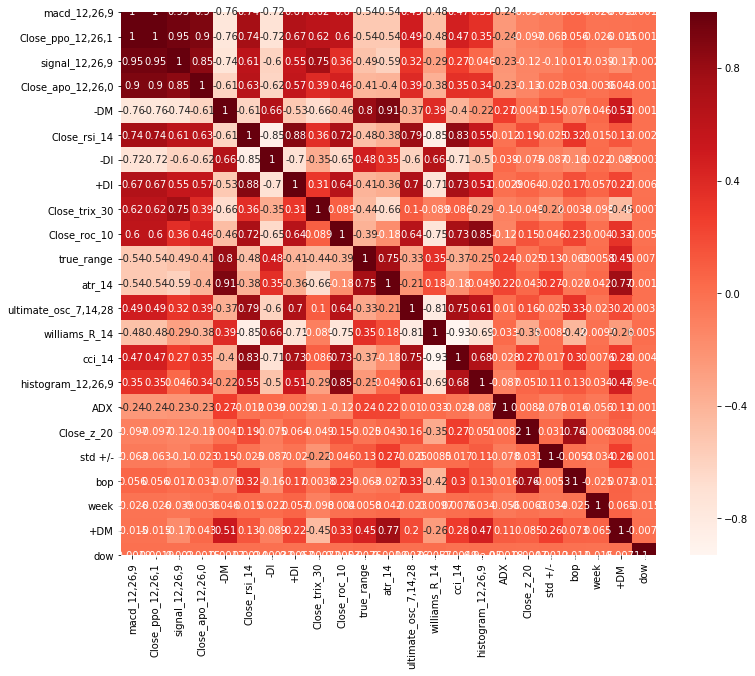

              macd_12,26,9  Close_ppo_12,26,1  signal_12,26,9  \
macd_12,26,9           1.0                1.0        0.951949   

              Close_apo_12,26,0       -DM  Close_rsi_14       -DI       +DI  \
macd_12,26,9           0.904932 -0.758217      0.744916 -0.716031  0.673393   

              Close_trix_30  Close_roc_10  ...  williams_R_14    cci_14  \
macd_12,26,9       0.618245      0.598297  ...      -0.482684  0.465316   

              histogram_12,26,9       ADX  Close_z_20   std +/-       bop  \
macd_12,26,9           0.349434 -0.238764    -0.09685 -0.063415  0.056463   

                  week       +DM       dow  
macd_12,26,9 -0.025925 -0.014531 -0.001901  

[1 rows x 23 columns]
label is continuous: True


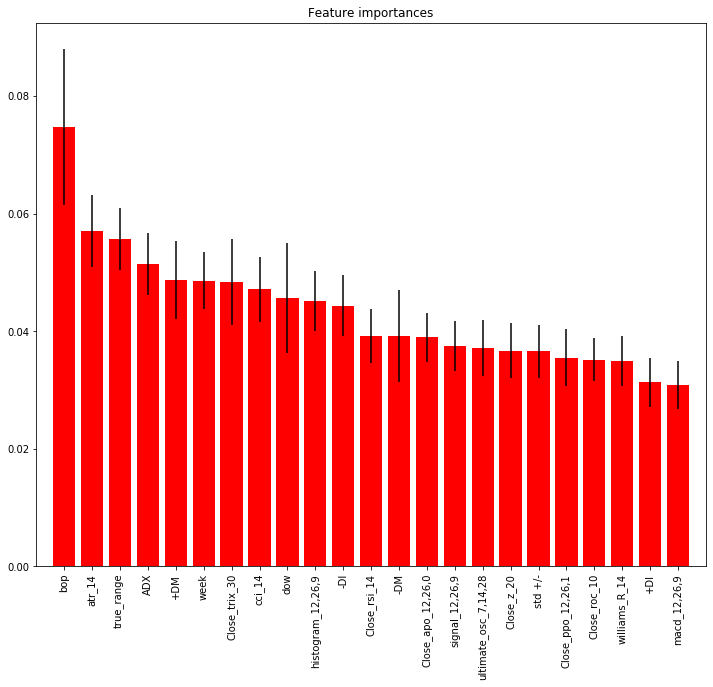

Feature ranking:
['bop', 'atr_14', 'true_range', 'ADX', '+DM', 'week', 'Close_trix_30', 'cci_14', 'dow', 'histogram_12,26,9', '-DI', 'Close_rsi_14', '-DM', 'Close_apo_12,26,0', 'signal_12,26,9', 'ultimate_osc_7,14,28', 'Close_z_20', 'std +/-', 'Close_ppo_12,26,1', 'Close_roc_10', 'williams_R_14', '+DI', 'macd_12,26,9']

TOP 5 features
     bop   atr_14  true_range       ADX      +DM
bop  1.0 -0.02695   -0.063425  0.016357  0.07312

filter feature atr_14 with correlation 1.0 > 0.5
Features after correlation filer:
                   bop       +DM  true_range       ADX
macd_12,26,9  0.056463 -0.014531   -0.536868 -0.238764


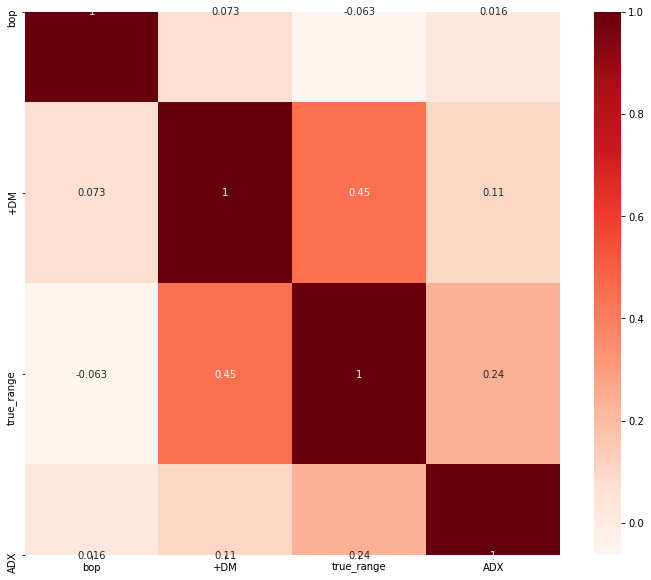

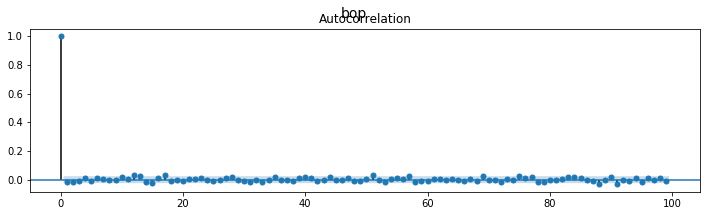

bop       1.000000
bop_0     1.000000
bop_51    0.034063
bop_17    0.031165
bop_12    0.030627
bop_75    0.024850
bop_57    0.024030
bop_69    0.023068
bop_13    0.022725
bop_84    0.021626
Name: bop, dtype: float64


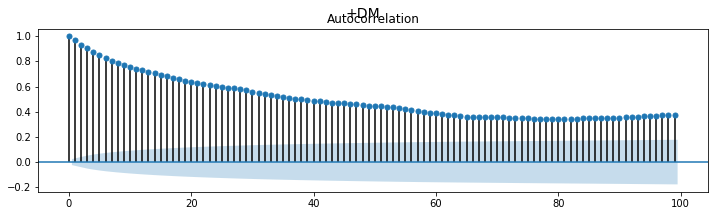

+DM      1.000000
+DM_0    1.000000
+DM_1    0.966103
+DM_2    0.932190
+DM_3    0.902415
+DM_4    0.874920
+DM_5    0.847614
+DM_6    0.823971
+DM_7    0.803094
+DM_8    0.786545
Name: +DM, dtype: float64


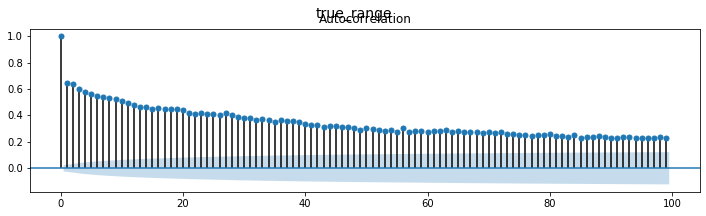

true_range      1.000000
true_range_0    1.000000
true_range_1    0.643817
true_range_2    0.636503
true_range_3    0.602148
true_range_4    0.579398
true_range_5    0.568577
true_range_6    0.553030
true_range_7    0.547112
true_range_8    0.536870
Name: true_range, dtype: float64


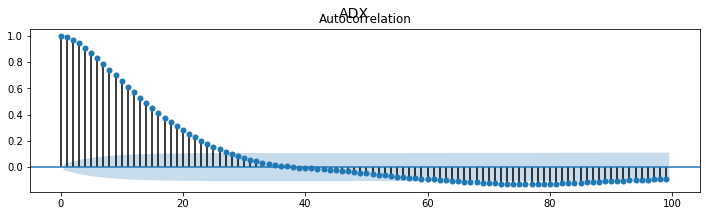

ADX      1.000000
ADX_0    1.000000
ADX_1    0.992782
ADX_2    0.973950
ADX_3    0.946559
ADX_4    0.912868
ADX_5    0.874735
ADX_6    0.833628
ADX_7    0.790635
ADX_8    0.746548
Name: ADX, dtype: float64
best lags are
[(1, '-1.00'), (2, '-0.65'), (3, '-0.63'), (4, '-0.61'), (5, '-0.60'), (6, '-0.57'), (7, '-0.56'), (8, '-0.54'), (9, '-0.52'), (10, '-0.50'), (11, '-0.49'), (12, '-0.46'), (13, '-0.45'), (14, '-0.44'), (15, '-0.41'), (16, '-0.39'), (17, '-0.39'), (18, '-0.38'), (19, '-0.36'), (20, '-0.35'), (21, '-0.34'), (22, '-0.33'), (23, '-0.32'), (24, '-0.31'), (25, '-0.30'), (26, '-0.29'), (28, '-0.28'), (27, '-0.28'), (29, '-0.28'), (30, '-0.26'), (31, '-0.25'), (32, '-0.24'), (33, '-0.24'), (34, '-0.23'), (35, '-0.23'), (36, '-0.23'), (37, '-0.22'), (38, '-0.22'), (40, '-0.22'), (39, '-0.21'), (41, '-0.21'), (42, '-0.20'), (45, '-0.20'), (43, '-0.20'), (44, '-0.19'), (46, '-0.19'), (48, '-0.19'), (47, '-0.19'), (52, '-0.18'), (49, '-0.18'), (51, '-0.18'), (50, '-0.17'), (53, '-0

In [6]:
features, lags = df.model.feature_selection(fnl)

In [7]:
features

['bop', 'atr_14', 'true_range', 'ADX', '+DM']

Now Lets have a closer look at this features - we try to see distinct clusters.

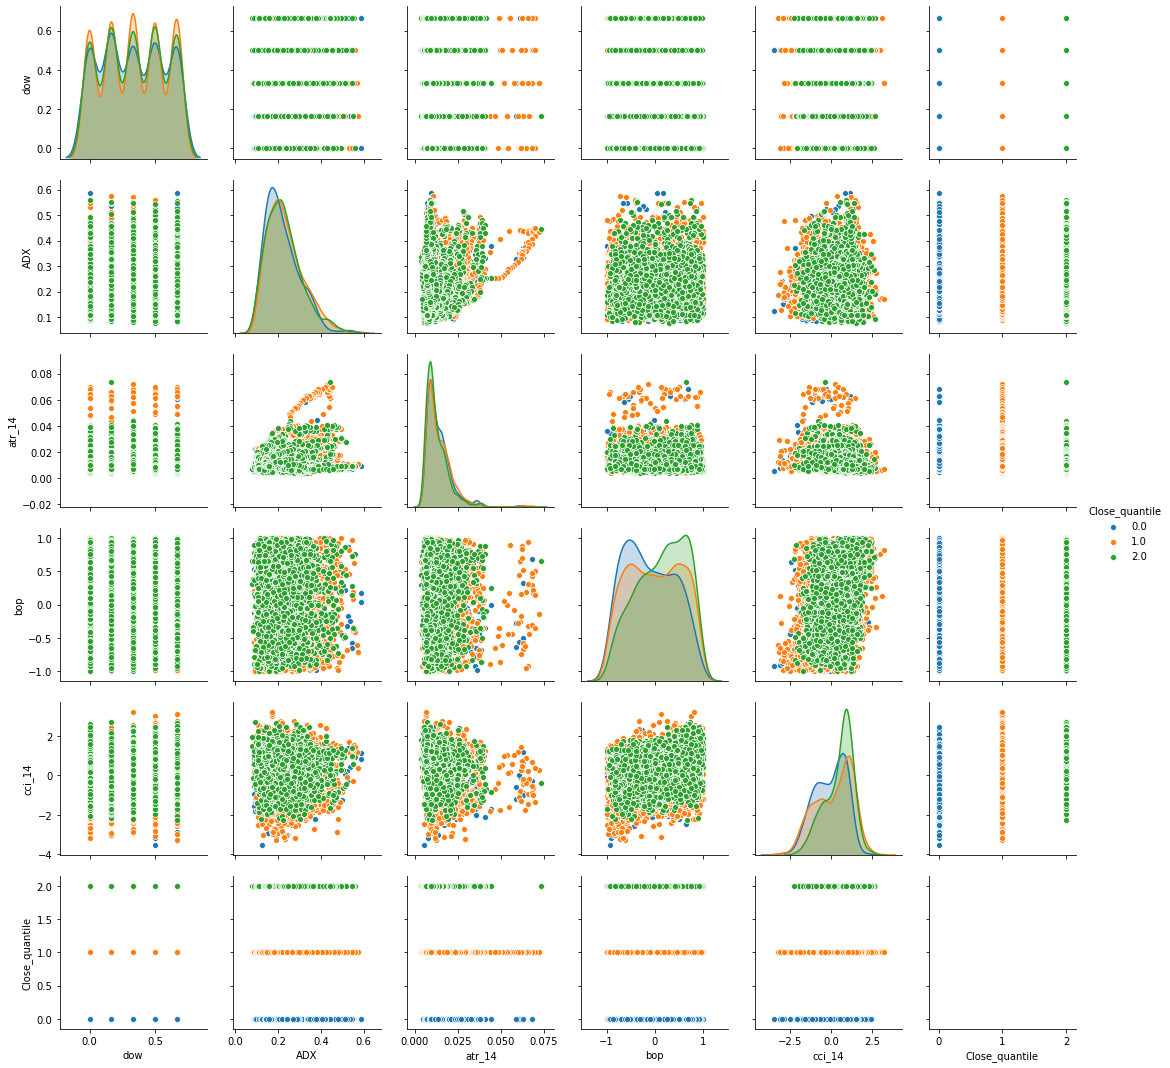

In [8]:
df.model.plot_features(
    FeaturesAndLabels(
        features=[
            lambda df: df["Close"].ta.week_day(),
            lambda df: df.ta.adx()[["ADX"]], 
            lambda df: df.ta.atr(),
            lambda df: df.ta.bop(),
            lambda df: df.ta.cci(),
        ],
        labels=[
            lambda df: df["Close"].ta.future_bband_quantile(5, 5, stddev=2.0)

        ],
        targets=[
            lambda df: df["Close"].ta.bbands(5, stddev=2.0)[["lower", "upper"]]
        ]
    )
)

Ideally we should see that there is some pattern which can seperate the features per label (color). 

So now we can build up a model from the learnings we have made. To make it a little more interesting we could use crossvalidation i.e. a K-Folds algorithm.

In [9]:
from pandas_ml_utils.ml.data.splitting import RandomSplits
from pandas_ml_utils.ml.data.splitting.sampeling import KFoldBoostRareEvents, KEquallyWeightEvents

fit = df.model.fit(
    SkModel(
        MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 50), random_state=42, alpha=2.0),
        FeaturesAndLabels(
            features=extract_with_post_processor(
                [
                    lambda df: df["Close"].ta.week_day(),
                    lambda df: df.ta.adx()[["ADX"]], 
                    lambda df: df.ta.atr(),
                    lambda df: df.ta.bop(),
                    lambda df: df.ta.cci(),
                ],
                lambda df: df.ta.rnn(lags)
            ),
            labels=[
                lambda df: df["Close"].ta.future_bband_quantile(5, 5, stddev=2.0).ta.one_hot_encode_discrete()

            ],
            targets=[
                lambda df: df["Close"].ta.bbands(5, stddev=2.0)[["lower", "upper"]]
            ]
        ),
        summary_provider=ClassificationSummary,
    ),
    RandomSplits(cross_validation=(1, KFoldBoostRareEvents(3).split))
)

fit

This obviously is not the besst model but you got the Idea. Also not the quite large penalization term which is "engineered" by trail and error. However One could also use the Hyperparameter optimization possibility:

```python
fit = df.model.fit(
    SkModel(...),
    test_size=0.4,
    test_validate_split_seed=42,
    hyper_parameter_space={'alpha': hp.choice('alpha', [0.0001, 10]), 'max_iter': 50,
                           '__max_evals': 4, '__rstate': np.random.RandomState(42)}
```

The leading `__` is used as a prefix for parameters passed to [hyperopt](https://github.com/hyperopt/hyperopt). All other parameters are passed to the model, like `max_iter` or `alpha` are parameters passed to the sklearn MLClassifier.

Ok now if we want to know what the current prediction is for the next 5 days, we simply call

```python
df.model.predict(fit.model)[-1:]["prediction"]
# [[6.13729022e-06, 9.99999839e-01, 1.07792629e-08]]
```

Oh wait now we know that we expect the price to be in the middle band but what does this actually mean? Which values are the middle band?
This is where the target comes into play.

In [10]:
df.model.predict(fit.model, tail=3).map_prediction_to_target()

prediction
2020-03-13 (-inf, 240.29)      0.000486
           (240.29, 298.32)    0.852968
           (298.32, inf)       0.526773
2020-03-16 (-inf, 223.11)      0.002558
           (223.11, 301.83)    0.979244
           (301.83, inf)       0.024657
2020-03-17 (-inf, 226.5)       0.000076
           (226.5, 284.27)     0.969900
           (284.27, inf)       0.459920

### Saving and Loading
Of corse we can save and load this model and just apply it to the data frame.

In [11]:
fit.model.save("/tmp/readme_model.dill")
model2 = Model.load("/tmp/readme_model.dill")
df.model.predict(model2, tail=1)

saved model to: /tmp/readme_model.dill


target              \
                 lower       upper   
Date                                 
2020-03-17  226.504997  284.271003   

                                                   prediction   feature  \
                                               Close_quantile  (0, dow)   
Date                                                                      
2020-03-17  [7.583555912951335e-05, 0.9673999702957446, 0....  0.166667   

                                                                     ...  \
           (1, dow)  (2, dow) (3, dow)  (4, dow)  (5, dow) (6, dow)  ...   
Date                                                                 ...   
2020-03-17      0.0  0.666667      0.5  0.333333  0.166667      0.0  ...   

                                                                             \
           (78, cci_14) (83, cci_14) (86, cci_14) (87, cci_14) (82, cci_14)   
Date                                                                          
2020-03-17     0.483038     0.836347     0.818793     1.017147      1.45627   

                                                                             
           (88, cci_14) (89, cci_14) (80, cci_14) (92, cci_14) (79, cci_14)  
Date                                                                         
2020-03-17     1.280774     1.034942     1.407302      1.53055     0.750388  

[1 rows x 508 columns]